In [2]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 20.0)

In [3]:
#import data from CSV from scope, skip few rows to avoid headers
data = np.genfromtxt(open("/Users/michaelkapuscik/git/mkapuscik.github.io/assets/NewFile6.csv","rb"), delimiter=',', skiprows=10, unpack=True)
#check to see if the data imported
print data[0:2][0:10]

[[ 0.16  0.16  0.16 ...,  0.16  0.16  0.16]
 [ 4.    4.    4.   ...,  4.    4.    4.  ]]


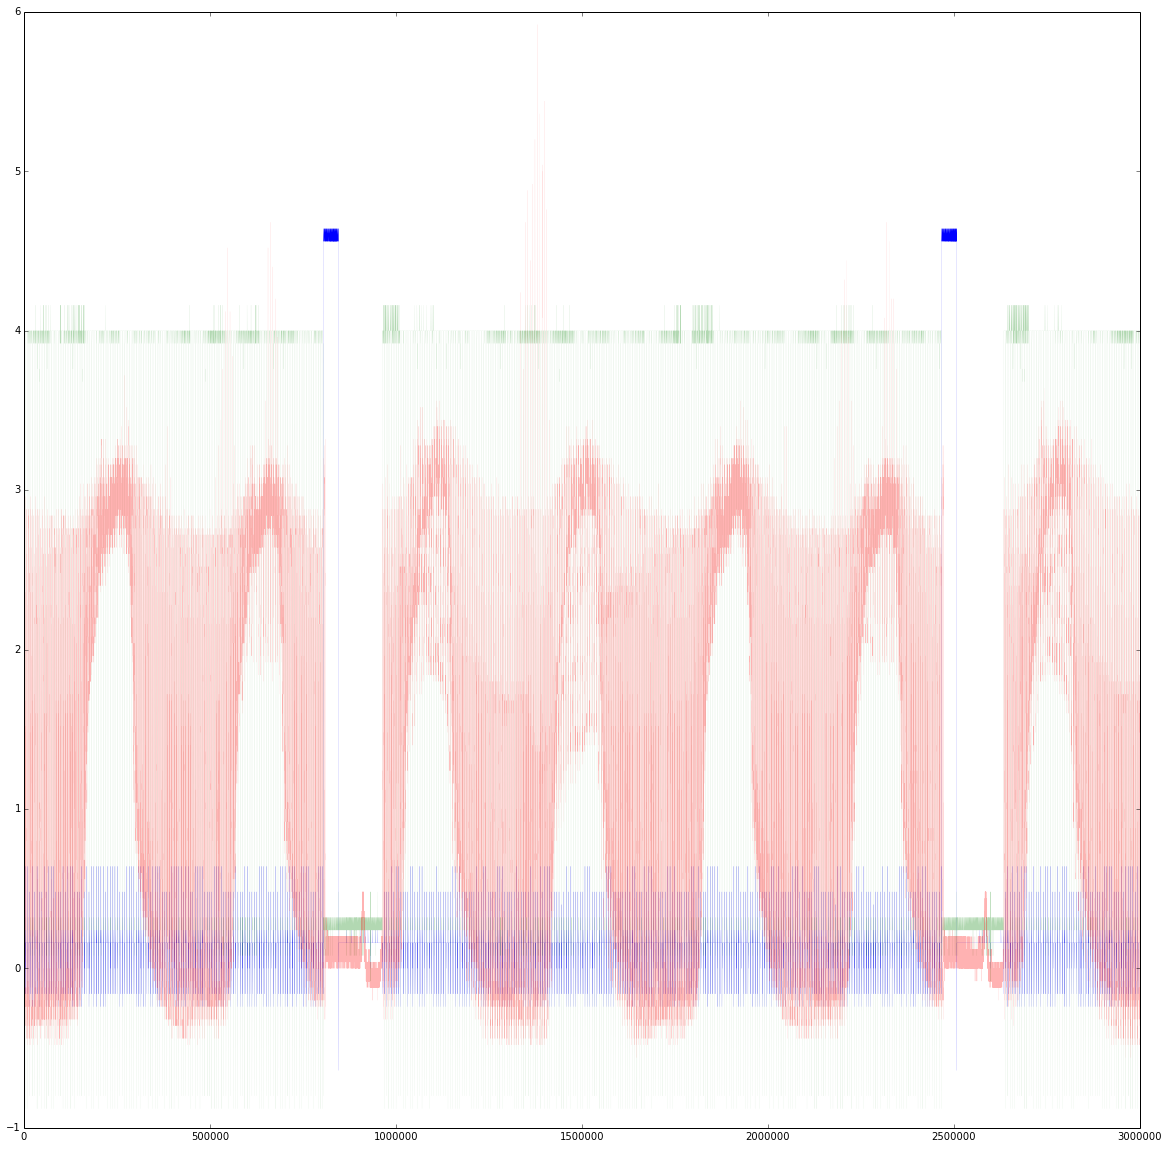

In [10]:
#plot the raw data to ensure it matches what we see on the oscilloscope
plt.plot(np.linspace(0,len(data[0]), len(data[1])), data[0], linewidth=0.1, alpha=1)
plt.plot(np.linspace(0,len(data[0]), len(data[1])), data[1], linewidth=0.1, alpha=0.3)
plt.plot(np.linspace(0,len(data[0]), len(data[1])), data[2], linewidth=0.1, alpha=0.3)

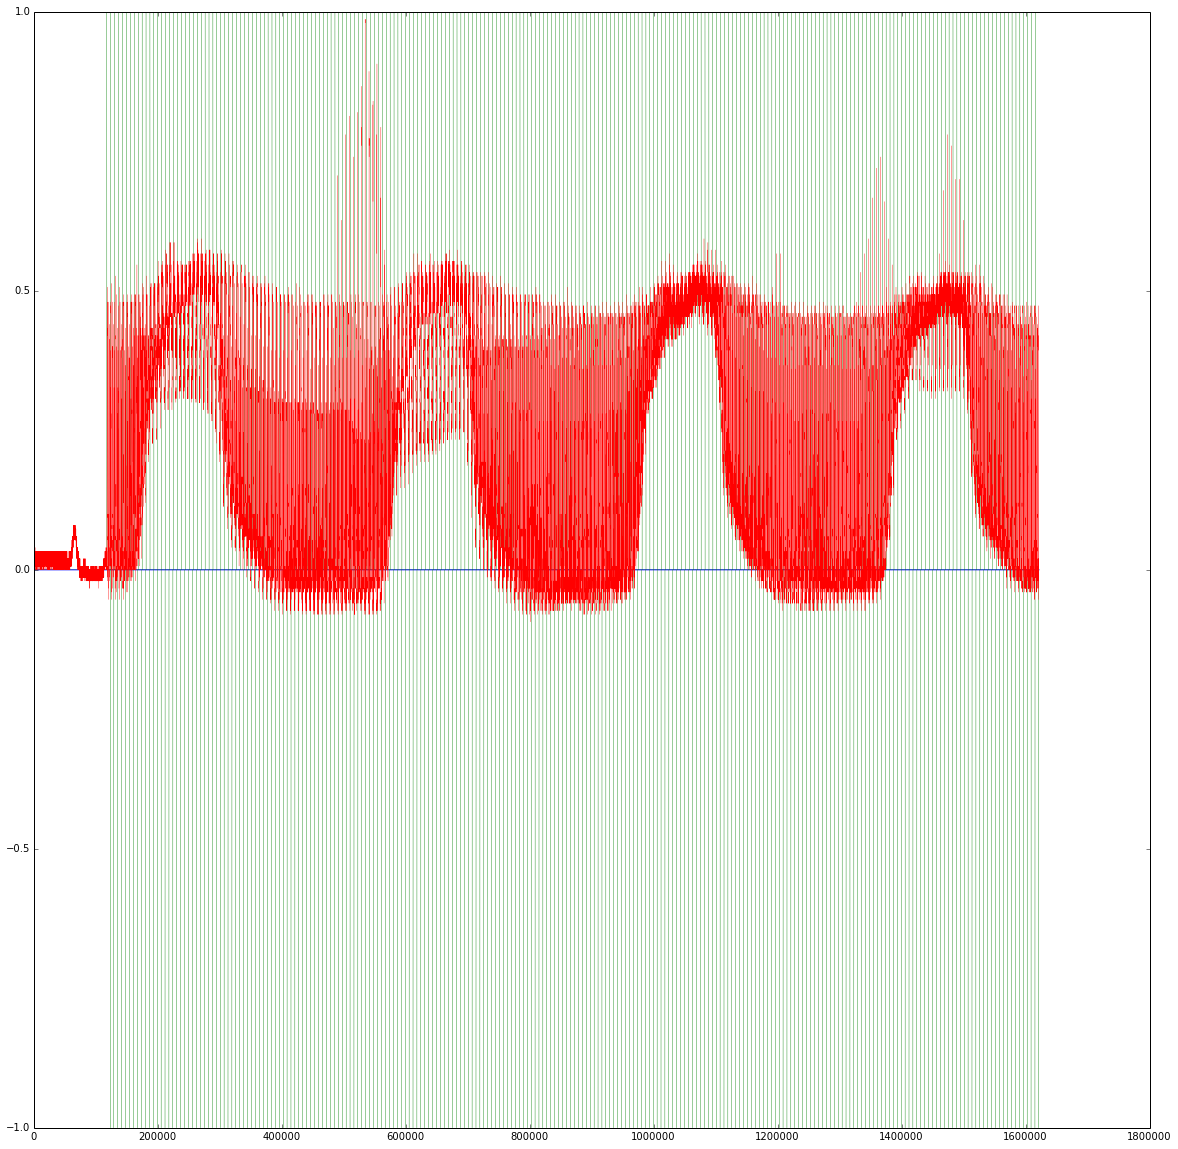

In [11]:
#clean up digital signals by thresholding
filtered_line_sync = data[1].copy()
#need to add in threshold detection to support arbitrary voltage offset from scope
filtered_line_sync[np.where(data[1] < 2)] = 0
filtered_line_sync[np.where(data[1] >= 2)] = 1

filtered_frame_sync = data[0].copy()
filtered_frame_sync[np.where(data[0] < 2)] = 0
filtered_frame_sync[np.where(data[0] >= 2)] = 1

#get frame boundries by differentiating digital framesync data and finding the first non-zero value
frame_edges = np.where(np.diff(filtered_frame_sync) != 0)
frame_start = frame_edges[0][1]
frame_stop = frame_edges[0][2]

#plot single frame of data to check assumptions
plt.plot(filtered_frame_sync[frame_start:frame_stop])
plt.plot(np.diff(filtered_line_sync[frame_start:frame_stop]), linewidth=0.2)
plt.plot(data[2][frame_start:frame_stop]/6, linewidth=0.2)


In [13]:
#count number of line signal transitions by pl
line_start = np.where(np.diff(filtered_line_sync[frame_start:frame_stop]) > 0)[0]
line_stop = np.where(np.diff(filtered_line_sync[frame_start:frame_stop]) < 0)[0]
print "Line positive edges: %i, Line negative edges: %i" % (len(line_start), len(line_stop))

#get just single frame worth of data so indexing is easier
frame_lines = data[1][frame_start:frame_stop]
frame_intensities = data[2][frame_start:frame_stop]

Line Positive edges: 237, Line negative edges: 237


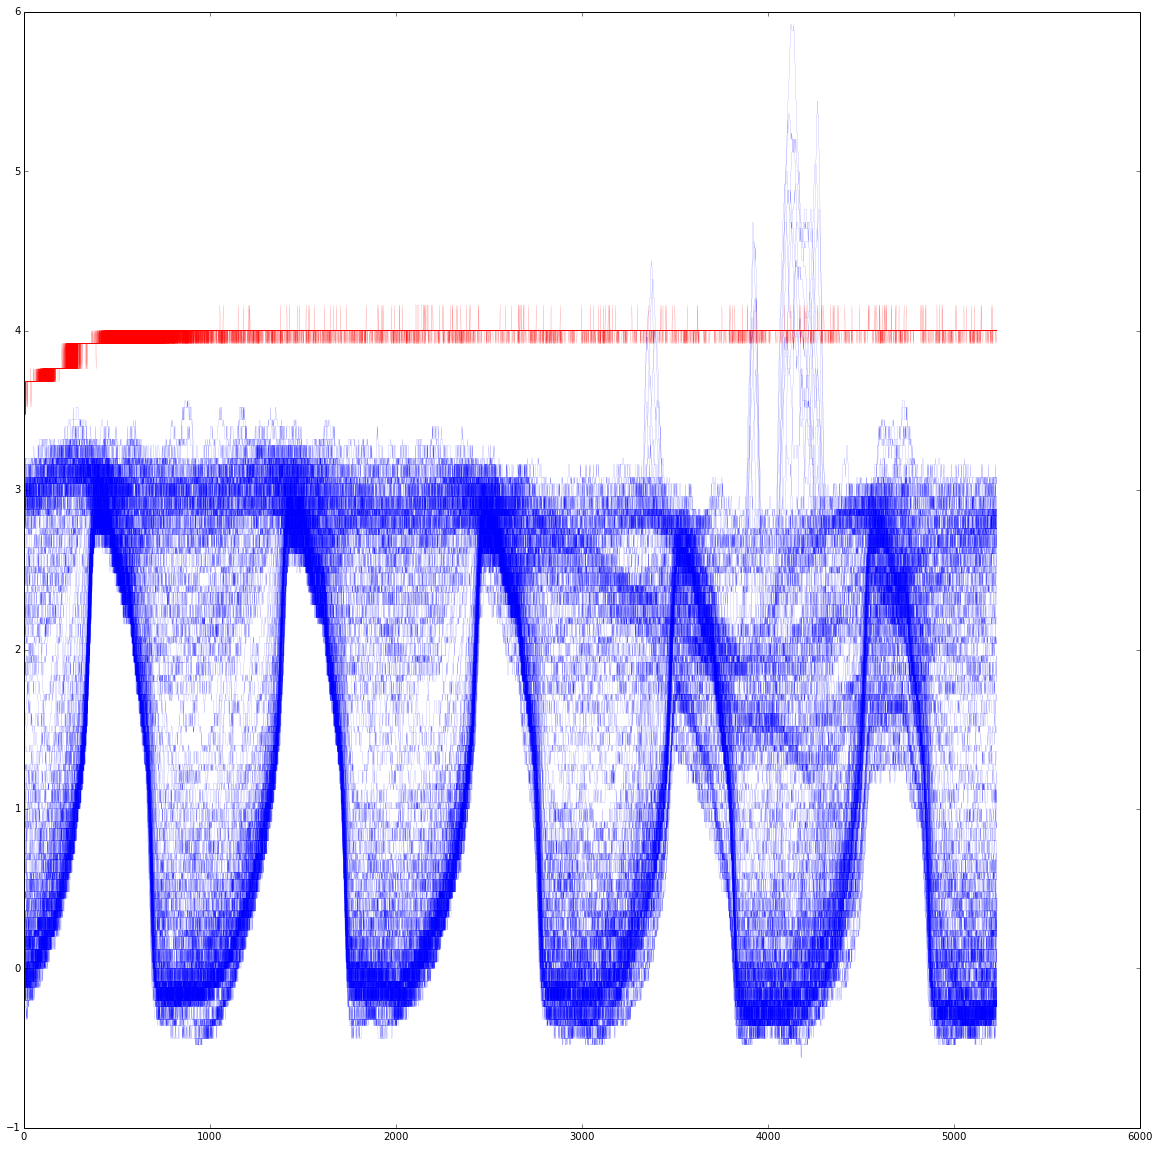

In [16]:
#plot all of the line of data to verify assumptions and look for incorrect decoding
for lineNum in range(len(line_start)):
    plt.plot(frame_intensities[line_start[lineNum]:line_stop[lineNum]], color="blue", linewidth=0.1)
    plt.plot(frame_lines[line_start[lineNum]:line_stop[lineNum]], color="red", linewidth=0.1)


In [19]:
#wrap the np.interp function to be a little more user friendly
def interpolate_line_data(line_beginning, line_end, data, frame_num, interpolation_size = 256):
    x = np.linspace(line_beginning[frame_num], line_end[frame_num], line_end[frame_num] - line_beginning[frame_num])
    xvals = np.linspace(line_beginning[frame_num], line_end[frame_num], interpolation_size)
    interpolated = np.interp(xvals, x, frame_intensities[line_beginning[frame_num]:line_end[frame_num]])
    
    return interpolated

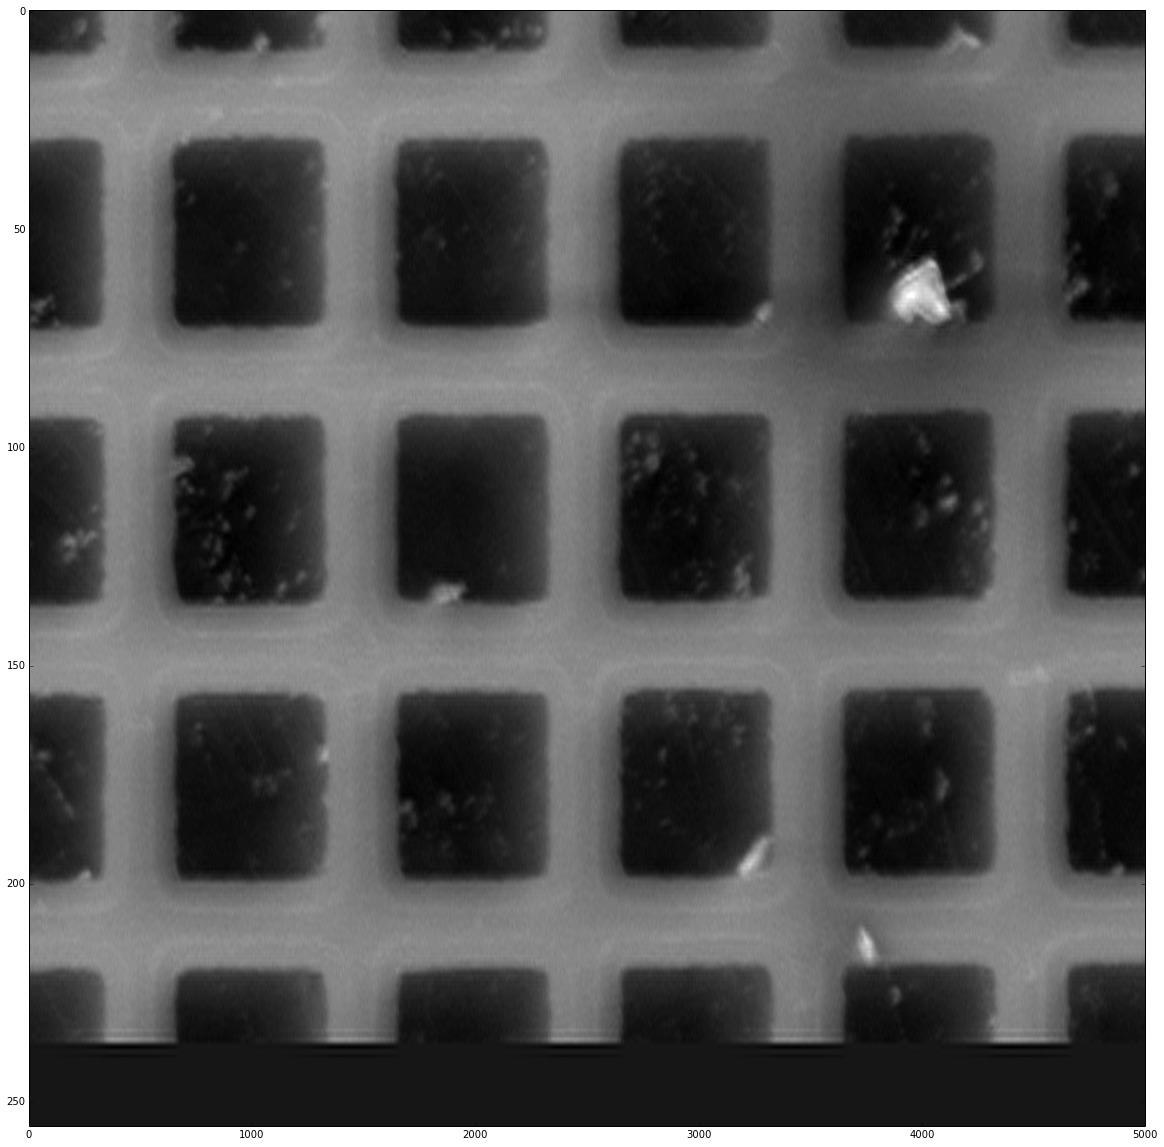

In [20]:
#create image array to hold decoded data, must be 256 lines vertically
image_width = 5000
image = np.ndarray(shape=(256,image_width))

#loop through lines and fill image with interpolated data on each line
#skip interpolating on vertical axis for now
for line in range(len(line_start)):
    image[line] = interpolate_line_data(line_start, line_stop, frame_intensities, line, interpolation_size=image_width)
    
transposed_image = np.transpose(image)
plt.imshow(image, interpolation='sinc', aspect='auto')
    
#plt.imshow(np.transpose(image))
plt.set_cmap("gray")